## **SETUP**

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
cd /content/drive/MyDrive/ColabProjects/OCT-Retinal-Disease-Detection-CNN

/content/drive/MyDrive/ColabProjects/retinal-disease-detection-oct-cnn


## **WORKING WITH DATA**

In [52]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchsummary import summary

import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os
import sys

In [53]:
# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [54]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU {torch.cuda.get_device_name(0)} is available")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead")

GPU Tesla T4 is available


In [55]:
# Load the datasets
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = ImageFolder(os.path.abspath('data/downsampled_datasets/train'), transform=transforms)
test_data = ImageFolder(os.path.abspath('data/downsampled_datasets/test'), transform=transforms)

In [56]:
image, target = train_data[0]

In [57]:
image.shape

torch.Size([3, 224, 224])

In [58]:
train_data

Dataset ImageFolder
    Number of datapoints: 12010
    Root location: /content/drive/MyDrive/ColabProjects/OCT-Retinal-Disease-Detection-CNN/data/downsampled_datasets/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [59]:
test_data

Dataset ImageFolder
    Number of datapoints: 498
    Root location: /content/drive/MyDrive/ColabProjects/OCT-Retinal-Disease-Detection-CNN/data/downsampled_datasets/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [60]:
train_data.class_to_idx

{'ABNORMAL': 0, 'NORMAL': 1}

Label: ABNORMAL


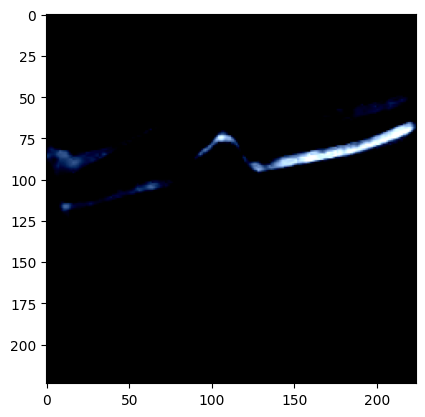

In [61]:
if target == 0:
  print(f"Label: ABNORMAL")
elif target == 1:
  print(f"Label: NORMAL")


image_data_rgb = np.transpose(image, (1, 2, 0))

plt.imshow(image_data_rgb, cmap='gray')
plt.show()

In [62]:
print(f'Number of NORMAL training images: {train_data.targets.count(1)}')
print(f'Number of ABNORMAL training images: {train_data.targets.count(0)}')

Number of NORMAL training images: 6010
Number of ABNORMAL training images: 6000


In [63]:
print(f'Number of NORMAL test images: {test_data.targets.count(1)}')
print(f'Number of ABNORMAL test images: {test_data.targets.count(0)}')

Number of NORMAL test images: 249
Number of ABNORMAL test images: 249


In [64]:
# Translate to dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, drop_last=True)

## **RESNET18**

In [72]:
resnet18 = torchvision.models.resnet18(weights='IMAGENET1K_V1')

In [73]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [74]:
summary(resnet18.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [75]:
# Freeze all layers
for name, param in resnet18.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

In [76]:
# Modify the final layer
resnet18.fc = nn.Linear(512, 2)

In [77]:
# Push the model to the GPU if available
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [78]:
lossfun18 = nn.CrossEntropyLoss()
optimizer18 = torch.optim.Adam(resnet18.parameters(), lr=0.001)

In [79]:
# test the model with one batch
X, y = next(iter(train_loader))
yHat = resnet18(X.to(device))

# check size of output
print('\Output size:')
print(yHat.shape)

# compute loss
loss = lossfun18(yHat, y.to(device))
print('\nLoss: ')
print(loss)

\Output size:
torch.Size([32, 2])

Loss: 
tensor(0.7986, device='cuda:0', grad_fn=<NllLossBackward0>)


In [80]:
# Function to train the model
def train_the_model(net, lossfun, optimizer):
  # number of epochs
  numepochs = 10

  # Send the model to the GPU
  lossfun.to(device)

  # initialize Losses
  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)
  trainAcc = torch.zeros(numepochs)
  testAcc = torch.zeros(numepochs)

  # Loop over the epochs
  for epoch in range(numepochs):

    # Loop over training data batches
    net.train()
    batchLoss = []
    batchAcc = []
    # for (X,y), count in zip(train_loader, range(len(train_loader))):
    for (X,y), count in zip(train_loader, range(1, len(train_loader))):

      # Push the data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Loss and error from this batch
      batchLoss.append(loss.item())
      batchAcc.append(torch.mean((torch.argmax(yHat , axis=1) == y).float()).item())
      msg = 'Completed {}/{}'.format(count, len(train_loader))
      sys.stdout.write('\r' + msg)

    # and get average losses and accuracies across the batches
    trainLoss[epoch] = np.mean(batchLoss)
    trainAcc[epoch]  = 100*np.mean(batchAcc)
    # end of batch loop...

    # test performance
    net.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    # for (X,y), count in zip(test_loader, range(len(test_loader))):
    for (X,y), count in zip(test_loader, range(1, len(test_loader))):

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat, y)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
      msg = 'Completed {}/{}'.format(count, len(test_loader))
      sys.stdout.write('\r' + msg)
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epoch] = np.mean(batchLoss)
    testAcc[epoch]  = 100*np.mean(batchAcc)
    print(f' Epoch {epoch+1}/{numepochs}')
  # end epochs


  # function output
  return trainLoss, testLoss, trainAcc, testAcc, net

In [81]:
trainLoss, testLoss, trainAcc, testAcc, resnet18 = train_the_model(resnet18, lossfun18, optimizer18)

Completed 14/15 Epoch 1/10
Completed 14/15 Epoch 2/10
Completed 14/15 Epoch 3/10
Completed 14/15 Epoch 4/10
Completed 14/15 Epoch 5/10
Completed 14/15 Epoch 6/10
Completed 14/15 Epoch 7/10
Completed 14/15 Epoch 8/10
Completed 14/15 Epoch 9/10
Completed 14/15 Epoch 10/10


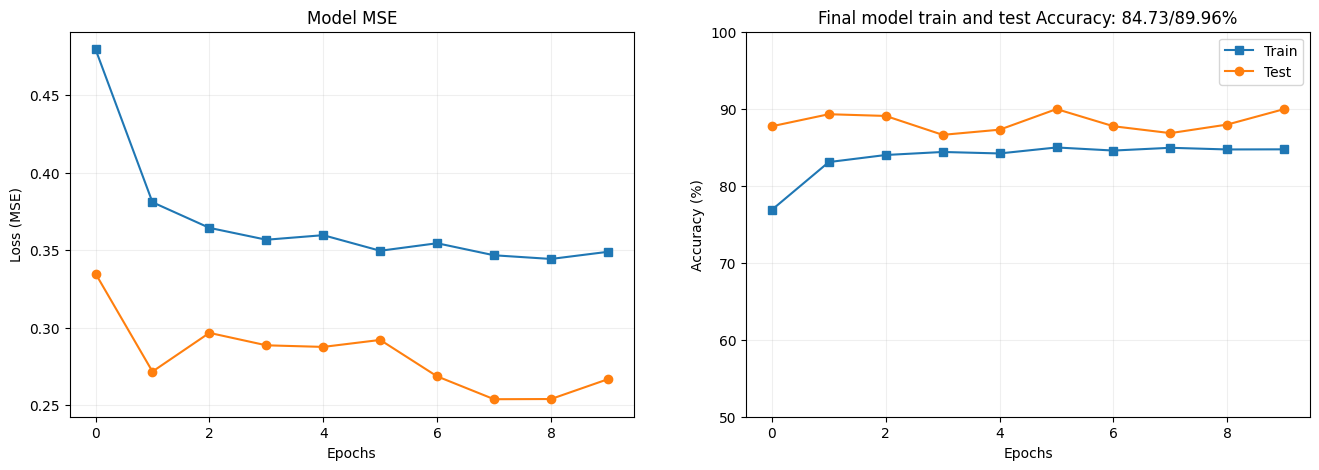

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model MSE')
ax[0].grid(alpha=0.2)

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train and test Accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].set_ylim(50, 100)
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.show()

## **RESNET50**

In [83]:
resnet50 = torchvision.models.resnet50(weights='IMAGENET1K_V1')

In [84]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [85]:
summary(resnet50.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [86]:
# Freeze all layers except feed forward layers
for name, param in resnet50.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

In [87]:
# Modify the final layer
resnet50.fc = nn.Linear(2048, 2)

In [88]:
# Push the model to the GPU if available
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [89]:
lossfun50 = nn.CrossEntropyLoss()
optimizer50 = torch.optim.Adam(resnet50.parameters(), lr=0.001)

In [90]:
# test the model with one batch
X, y = next(iter(train_loader))
yHat = resnet50(X.to(device))

# check size of output
print('\Output size:')
print(yHat.shape)

# compute loss
loss = lossfun50(yHat, y.to(device))
print('\nLoss: ')
print(loss)

\Output size:
torch.Size([32, 2])

Loss: 
tensor(0.7382, device='cuda:0', grad_fn=<NllLossBackward0>)


In [91]:
trainLoss, testLoss, trainAcc, testAcc, resnet50 = train_the_model(resnet50, lossfun50, optimizer50)

Completed 14/15 Epoch 1/10
Completed 14/15 Epoch 2/10
Completed 14/15 Epoch 3/10
Completed 14/15 Epoch 4/10
Completed 14/15 Epoch 5/10
Completed 14/15 Epoch 6/10
Completed 14/15 Epoch 7/10
Completed 14/15 Epoch 8/10
Completed 14/15 Epoch 9/10
Completed 14/15 Epoch 10/10


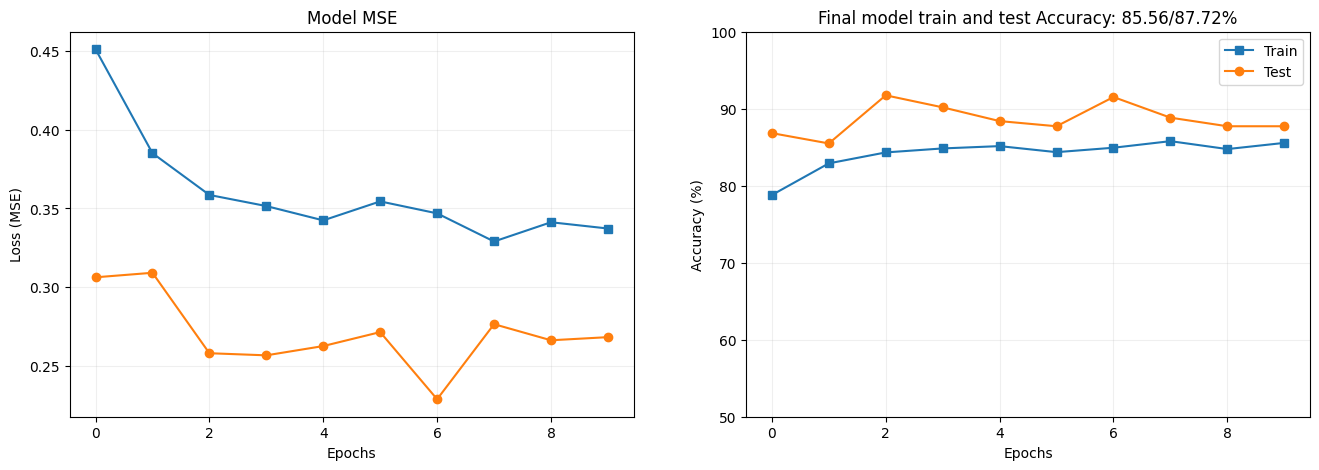

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model MSE')
ax[0].grid(alpha=0.2)

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train and test Accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].set_ylim(50, 100)
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.show()

## **VGG16**

In [98]:
vgg16 = torchvision.models.vgg16(weights='IMAGENET1K_V1')
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [99]:
summary(vgg16.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [100]:
# Freeze all layers except feed forward layers
for name, param in vgg16.named_parameters():
    if name not in ['classifier.weight', 'classifier.bias']:
        param.requires_grad = False

In [101]:
# Replace the final layer
vgg16.classifier[6] = nn.Linear(4096, 2)

In [102]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [103]:
lossfunv16 = nn.CrossEntropyLoss()
optimizerv16 = torch.optim.Adam(vgg16.parameters(), lr=0.001)

In [104]:
# test the model with one batch
X, y = next(iter(train_loader))
yHat = vgg16(X.to(device))

# check size of output
print('\Output size:')
print(yHat.shape)

# compute loss
loss = lossfunv16(yHat, y.to(device))
print('\nLoss: ')
print(loss)

\Output size:
torch.Size([32, 2])

Loss: 
tensor(0.7834, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
trainLoss, testLoss, trainAcc, testAcc, vgg16 = train_the_model(vgg16, lossfunv16, optimizerv16)

Completed 14/15 Epoch 1/10
Completed 14/15 Epoch 2/10
Completed 147/375

GPU Runtime exceeded on Colab!